# Creating a Training Loop for PyTorch Models

PyTorch provides a lot of building blocks for a deep learning model, but training loop is not part of them. 
It is a flexibility provided that you can do whatever you want during training, but some basic structure is universal across most use cases.
In this tutorial, you will see how to make a training loop that provides essential information for your model training, with the option to allow any information to be displayed. 

## Outcome

After completing this tutorial, you will know

- The basic building block of a training loop
- How to use tqdm to display training progress

## Overview

- Elements of Training a Deep Learning Model
- Collecting Statistics During Training
- Using tqdm to Report the Training Progress

## Elements of Training a Deep Learning Model

Same as all machine learning model, the model design specifies the algorithm to manipulate an input and produce an output. 
But in the model, there are parameters that you need to fine-tune to achieve that. 
These model parameters are also called the weights, biases, kernels, or other names depending on the particular model and layers. 
Training is to feed in sample data to the model so that an optimizer can fine-tune these parameters.

When you train a model, usually you start with a dataset. 
Each dataset is a fairly large number of data samples. 
When you get a dataset, it is recommended to split it into two portions, the training set and the test set. 
The training set is to further split into batches and use in the training loop to drive the gradient descent algorithms. 
The test set, however, is to use as a benchmark to tell how good is our model. 
Usually we do not use the training set as a metric but take the test set, which is not seen by the gradient descent algorithm, so we can tell if our model fit well to unseen data.

Overfitting is when the model fit too well to the training set (i.e., at a very high accuracy) but perform significantly worse in the test set. 
Underfitting is when the model cannot even fit well to the training set. 
Either are what you don't want to see on a good model.

Training of a neural network model is in epochs. 
Usually one epoch means we run through the entire training set once, although we take one batch at a time. 
It is also the custom that some housekeeping tasks are done at the end of each epoch, such as benchmarking the partially-trained model with the test set, checkpointing the model, decide if we want to stop the training early, collecting training statistics, and so on.

In each epoch, we feed data samples into the model in batches and run a gradient descent algorithm. 
This is one step in the training loop because we run the model in one forward pass (i.e., providing input and capturing output), and one backward pass (evaluating the loss metric from the output and deriving the gradient of each parameter all the way back to the input layer). 
The backward pass is to compute the gradient using automatic differentiation. 
Then, these gradient is used by the gradient descent algorithm to adjust the model parameters. 
There are multiple steps in one epoch.

Reuse the examples in a previous tutorial, you can downloaded the dataset and split the dataset into two as follows:

In [1]:
import numpy as np
import torch

# load the dataset
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = dataset[:,0:8]
y = dataset[:,8]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# split the dataset into training and test sets
Xtrain = X[:700]
ytrain = y[:700]
Xtest = X[700:]
ytest = y[700:]

This dataset is small, only 768 samples. 
Here it take first 700 as the training set and the rest as the test set.

It is not the focus of this tutorial, but you can reuse the model, the loss function, and the optimizer as in the previous tutorial:

In [2]:
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print(model)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)


With the data and the model, this is the minimal training loop, with the forward and backward pass in each step:

In [3]:
n_epochs = 50    # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size
 
for epoch in range(n_epochs):
    for i in range(batches_per_epoch):
        start = i * batch_size
        # take a batch
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

In the inner for-loop, you take each batch in the dataset and evaluate the loss. 
The loss is a PyTorch tensor that remembers how it comes up with its value. 
Then you zero-out all gradients that the optimizer manages, and call loss.backward() to run the backpropagation algorithm. 
The result is to set up the gradients of all the tensors that the tensor loss depends on directly and indirectly. 
Afterward, upon calling step(), the optimizer will check each parameter that it manages and update them.

After everything is done, we can run the model with the test set to evaluate its performance. 
The evaluation can be based on a different function than the loss function. 
For example, in this classification problem, we can use accuracy:

In [4]:
# evaluate trained model with test set
with torch.no_grad():
    y_pred = model(X)
accuracy = (y_pred.round() == y).float().mean()
print("Accuracy {:.2f}".format(accuracy * 100))

Accuracy 72.53


Putting everything together, this is the complete code:

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
 
# load the dataset
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = dataset[:,0:8]
y = dataset[:,8]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
 
# split the dataset into training and test sets
Xtrain = X[:700]
ytrain = y[:700]
Xtest = X[700:]
ytest = y[700:]
 
model = nn.Sequential(
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print(model)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 50    # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size
 
for epoch in range(n_epochs):
    for i in range(batches_per_epoch):
        start = i * batch_size
        # take a batch
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

# evaluate trained model with test set
with torch.no_grad():
    y_pred = model(X)
accuracy = (y_pred.round() == y).float().mean()
print("Accuracy {:.2f}".format(accuracy * 100))

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)
Accuracy 75.39


## Collecting Statistics During Training

The training loop above should work well with small models that can finish training in a few seconds. 
But for a larger model or a larger dataset, you will find that it takes significant longer time to train. 
While you're waiting for the training to complete, you may want to see how it goes as you may want to interrupt the training if any mistake is made.

Usually during training, we would like to see the following:

- In each step, we would like to know the loss metrics, and we are expecting the loss to go down
- In each step, we would like to know other metrics, such as accuracy on the training set, that is of interest to us but not involved in the gradient descent
- At end of each epoch, we would like to evaluate the partially-trained model with the test set and report the evaluation metric
- At the end of training, we would like to be above to visualize the above metrics

These all are possible but we need to add more code into the training loop, as follows:

In [6]:
n_epochs = 50    # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size
 
# collect statistics
train_loss = []
train_acc = []
test_acc = []
 
for epoch in range(n_epochs):
    for i in range(batches_per_epoch):
        start = i * batch_size
        # take a batch
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store metrics
        train_loss.append(float(loss))
        train_acc.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        print(f"epoch {epoch} step {i} loss {loss} accuracy {acc}")
    # evaluate model at end of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f"End of {epoch}, accuracy {acc}")

epoch 0 step 0 loss 0.7220504283905029 accuracy 0.699999988079071
epoch 0 step 1 loss 0.6782894134521484 accuracy 0.699999988079071
epoch 0 step 2 loss 0.5824698805809021 accuracy 0.6000000238418579
epoch 0 step 3 loss 0.5970994234085083 accuracy 0.6000000238418579
epoch 0 step 4 loss 0.5615760087966919 accuracy 0.5
epoch 0 step 5 loss 0.4363798499107361 accuracy 0.699999988079071
epoch 0 step 6 loss 0.4600718021392822 accuracy 0.800000011920929
epoch 0 step 7 loss 0.5335770845413208 accuracy 0.699999988079071
epoch 0 step 8 loss 0.5227595567703247 accuracy 0.699999988079071
epoch 0 step 9 loss 0.5492775440216064 accuracy 0.699999988079071
epoch 0 step 10 loss 0.7185066938400269 accuracy 0.6000000238418579
epoch 0 step 11 loss 0.39884644746780396 accuracy 0.800000011920929
epoch 0 step 12 loss 0.7898045182228088 accuracy 0.5
epoch 0 step 13 loss 0.44117623567581177 accuracy 0.800000011920929
epoch 0 step 14 loss 0.45337486267089844 accuracy 0.8999999761581421
epoch 0 step 15 loss 0.495

epoch 1 step 66 loss 0.7753438949584961 accuracy 0.4000000059604645
epoch 1 step 67 loss 0.4302784502506256 accuracy 0.800000011920929
epoch 1 step 68 loss 0.5773134827613831 accuracy 0.699999988079071
epoch 1 step 69 loss 0.5959166884422302 accuracy 0.6000000238418579
End of 1, accuracy 0.7058823704719543
epoch 2 step 0 loss 0.7048454284667969 accuracy 0.699999988079071
epoch 2 step 1 loss 0.6825326085090637 accuracy 0.699999988079071
epoch 2 step 2 loss 0.5805214643478394 accuracy 0.5
epoch 2 step 3 loss 0.597170889377594 accuracy 0.6000000238418579
epoch 2 step 4 loss 0.5608116984367371 accuracy 0.5
epoch 2 step 5 loss 0.4315716326236725 accuracy 0.699999988079071
epoch 2 step 6 loss 0.45774731040000916 accuracy 0.800000011920929
epoch 2 step 7 loss 0.5297430157661438 accuracy 0.699999988079071
epoch 2 step 8 loss 0.5218042135238647 accuracy 0.699999988079071
epoch 2 step 9 loss 0.542291522026062 accuracy 0.699999988079071
epoch 2 step 10 loss 0.7197202444076538 accuracy 0.600000023

epoch 4 step 2 loss 0.5777422785758972 accuracy 0.6000000238418579
epoch 4 step 3 loss 0.6027522683143616 accuracy 0.6000000238418579
epoch 4 step 4 loss 0.563396692276001 accuracy 0.5
epoch 4 step 5 loss 0.42473483085632324 accuracy 0.699999988079071
epoch 4 step 6 loss 0.45739856362342834 accuracy 0.800000011920929
epoch 4 step 7 loss 0.5246425867080688 accuracy 0.699999988079071
epoch 4 step 8 loss 0.5206471681594849 accuracy 0.699999988079071
epoch 4 step 9 loss 0.5393123626708984 accuracy 0.699999988079071
epoch 4 step 10 loss 0.7223609685897827 accuracy 0.6000000238418579
epoch 4 step 11 loss 0.3912063539028168 accuracy 0.8999999761581421
epoch 4 step 12 loss 0.7855774760246277 accuracy 0.5
epoch 4 step 13 loss 0.43321123719215393 accuracy 0.800000011920929
epoch 4 step 14 loss 0.45627593994140625 accuracy 0.8999999761581421
epoch 4 step 15 loss 0.485013872385025 accuracy 0.800000011920929
epoch 4 step 16 loss 0.6259418725967407 accuracy 0.699999988079071
epoch 4 step 17 loss 0.8

epoch 6 step 0 loss 0.6736971139907837 accuracy 0.699999988079071
epoch 6 step 1 loss 0.6760077476501465 accuracy 0.699999988079071
epoch 6 step 2 loss 0.564056932926178 accuracy 0.6000000238418579
epoch 6 step 3 loss 0.6068084836006165 accuracy 0.6000000238418579
epoch 6 step 4 loss 0.5652037262916565 accuracy 0.5
epoch 6 step 5 loss 0.42887020111083984 accuracy 0.699999988079071
epoch 6 step 6 loss 0.45694607496261597 accuracy 0.800000011920929
epoch 6 step 7 loss 0.5158436298370361 accuracy 0.699999988079071
epoch 6 step 8 loss 0.5188289284706116 accuracy 0.699999988079071
epoch 6 step 9 loss 0.5418431758880615 accuracy 0.699999988079071
epoch 6 step 10 loss 0.7140113115310669 accuracy 0.6000000238418579
epoch 6 step 11 loss 0.385882169008255 accuracy 0.8999999761581421
epoch 6 step 12 loss 0.7790075540542603 accuracy 0.5
epoch 6 step 13 loss 0.43255001306533813 accuracy 0.800000011920929
epoch 6 step 14 loss 0.45382434129714966 accuracy 0.8999999761581421
epoch 6 step 15 loss 0.477

epoch 8 step 13 loss 0.4321478307247162 accuracy 0.800000011920929
epoch 8 step 14 loss 0.4607108235359192 accuracy 0.8999999761581421
epoch 8 step 15 loss 0.4672495424747467 accuracy 0.800000011920929
epoch 8 step 16 loss 0.627515435218811 accuracy 0.800000011920929
epoch 8 step 17 loss 0.8120256662368774 accuracy 0.5
epoch 8 step 18 loss 0.5779315233230591 accuracy 0.699999988079071
epoch 8 step 19 loss 0.6190055012702942 accuracy 0.699999988079071
epoch 8 step 20 loss 0.3828495144844055 accuracy 0.800000011920929
epoch 8 step 21 loss 0.6582422256469727 accuracy 0.6000000238418579
epoch 8 step 22 loss 0.42673054337501526 accuracy 0.6000000238418579
epoch 8 step 23 loss 0.43554049730300903 accuracy 0.800000011920929
epoch 8 step 24 loss 0.5188618898391724 accuracy 0.699999988079071
epoch 8 step 25 loss 0.47154340147972107 accuracy 0.800000011920929
epoch 8 step 26 loss 0.43591180443763733 accuracy 0.800000011920929
epoch 8 step 27 loss 0.4227272868156433 accuracy 0.800000011920929
epo

epoch 10 step 33 loss 0.4016660749912262 accuracy 0.8999999761581421
epoch 10 step 34 loss 0.45107316970825195 accuracy 0.800000011920929
epoch 10 step 35 loss 0.3845089375972748 accuracy 0.800000011920929
epoch 10 step 36 loss 0.5937101244926453 accuracy 0.6000000238418579
epoch 10 step 37 loss 0.36493146419525146 accuracy 0.800000011920929
epoch 10 step 38 loss 0.5002619028091431 accuracy 0.800000011920929
epoch 10 step 39 loss 0.41247838735580444 accuracy 0.8999999761581421
epoch 10 step 40 loss 0.5571704506874084 accuracy 0.699999988079071
epoch 10 step 41 loss 0.4972567558288574 accuracy 0.6000000238418579
epoch 10 step 42 loss 0.44222933053970337 accuracy 0.8999999761581421
epoch 10 step 43 loss 0.47723039984703064 accuracy 0.699999988079071
epoch 10 step 44 loss 0.47736501693725586 accuracy 0.8999999761581421
epoch 10 step 45 loss 0.25647908449172974 accuracy 1.0
epoch 10 step 46 loss 0.4310937821865082 accuracy 0.800000011920929
epoch 10 step 47 loss 0.6480733156204224 accuracy

epoch 12 step 59 loss 0.6054999828338623 accuracy 0.6000000238418579
epoch 12 step 60 loss 0.4345868229866028 accuracy 0.800000011920929
epoch 12 step 61 loss 0.47176218032836914 accuracy 0.800000011920929
epoch 12 step 62 loss 0.24210789799690247 accuracy 0.8999999761581421
epoch 12 step 63 loss 0.5437106490135193 accuracy 0.699999988079071
epoch 12 step 64 loss 0.5393414497375488 accuracy 0.699999988079071
epoch 12 step 65 loss 0.6133826971054077 accuracy 0.800000011920929
epoch 12 step 66 loss 0.764850914478302 accuracy 0.4000000059604645
epoch 12 step 67 loss 0.4167203903198242 accuracy 0.800000011920929
epoch 12 step 68 loss 0.5606529116630554 accuracy 0.699999988079071
epoch 12 step 69 loss 0.567089855670929 accuracy 0.6000000238418579
End of 12, accuracy 0.720588207244873
epoch 13 step 0 loss 0.6347219944000244 accuracy 0.699999988079071
epoch 13 step 1 loss 0.6671392321586609 accuracy 0.699999988079071
epoch 13 step 2 loss 0.5565658807754517 accuracy 0.6000000238418579
epoch 13

epoch 15 step 6 loss 0.4532713294029236 accuracy 0.800000011920929
epoch 15 step 7 loss 0.5095676183700562 accuracy 0.699999988079071
epoch 15 step 8 loss 0.5091065168380737 accuracy 0.699999988079071
epoch 15 step 9 loss 0.5384083986282349 accuracy 0.699999988079071
epoch 15 step 10 loss 0.7207409143447876 accuracy 0.6000000238418579
epoch 15 step 11 loss 0.3648567795753479 accuracy 1.0
epoch 15 step 12 loss 0.7719002366065979 accuracy 0.5
epoch 15 step 13 loss 0.4256013035774231 accuracy 0.800000011920929
epoch 15 step 14 loss 0.457872211933136 accuracy 0.800000011920929
epoch 15 step 15 loss 0.4587194323539734 accuracy 0.800000011920929
epoch 15 step 16 loss 0.6190773248672485 accuracy 0.800000011920929
epoch 15 step 17 loss 0.816567063331604 accuracy 0.6000000238418579
epoch 15 step 18 loss 0.5688307881355286 accuracy 0.699999988079071
epoch 15 step 19 loss 0.6254938840866089 accuracy 0.699999988079071
epoch 15 step 20 loss 0.36470428109169006 accuracy 0.800000011920929
epoch 15 st

epoch 17 step 4 loss 0.5458689332008362 accuracy 0.6000000238418579
epoch 17 step 5 loss 0.42094096541404724 accuracy 0.800000011920929
epoch 17 step 6 loss 0.4510015845298767 accuracy 0.800000011920929
epoch 17 step 7 loss 0.5105693340301514 accuracy 0.699999988079071
epoch 17 step 8 loss 0.5040705800056458 accuracy 0.699999988079071
epoch 17 step 9 loss 0.5391244292259216 accuracy 0.699999988079071
epoch 17 step 10 loss 0.7213610410690308 accuracy 0.6000000238418579
epoch 17 step 11 loss 0.35702356696128845 accuracy 1.0
epoch 17 step 12 loss 0.7707986831665039 accuracy 0.5
epoch 17 step 13 loss 0.4298361837863922 accuracy 0.800000011920929
epoch 17 step 14 loss 0.477468878030777 accuracy 0.800000011920929
epoch 17 step 15 loss 0.46720942854881287 accuracy 0.800000011920929
epoch 17 step 16 loss 0.633000373840332 accuracy 0.699999988079071
epoch 17 step 17 loss 0.8080838918685913 accuracy 0.6000000238418579
epoch 17 step 18 loss 0.5563699007034302 accuracy 0.699999988079071
epoch 17 s

epoch 19 step 64 loss 0.5245128870010376 accuracy 0.699999988079071
epoch 19 step 65 loss 0.6107323169708252 accuracy 0.800000011920929
epoch 19 step 66 loss 0.7487727403640747 accuracy 0.4000000059604645
epoch 19 step 67 loss 0.4118918478488922 accuracy 0.800000011920929
epoch 19 step 68 loss 0.5549864768981934 accuracy 0.699999988079071
epoch 19 step 69 loss 0.5554509162902832 accuracy 0.6000000238418579
End of 19, accuracy 0.7352941036224365
epoch 20 step 0 loss 0.6054596304893494 accuracy 0.699999988079071
epoch 20 step 1 loss 0.6745210886001587 accuracy 0.6000000238418579
epoch 20 step 2 loss 0.5377024412155151 accuracy 0.699999988079071
epoch 20 step 3 loss 0.625038206577301 accuracy 0.6000000238418579
epoch 20 step 4 loss 0.5596987009048462 accuracy 0.6000000238418579
epoch 20 step 5 loss 0.425506055355072 accuracy 0.800000011920929
epoch 20 step 6 loss 0.449819952249527 accuracy 0.800000011920929
epoch 20 step 7 loss 0.4970654845237732 accuracy 0.699999988079071
epoch 20 step 8

epoch 21 step 49 loss 0.3871530592441559 accuracy 0.800000011920929
epoch 21 step 50 loss 0.40944400429725647 accuracy 0.8999999761581421
epoch 21 step 51 loss 0.5093976259231567 accuracy 0.6000000238418579
epoch 21 step 52 loss 0.30438321828842163 accuracy 0.8999999761581421
epoch 21 step 53 loss 0.3487505614757538 accuracy 0.8999999761581421
epoch 21 step 54 loss 0.48627156019210815 accuracy 0.800000011920929
epoch 21 step 55 loss 0.250119686126709 accuracy 0.8999999761581421
epoch 21 step 56 loss 0.39913395047187805 accuracy 0.800000011920929
epoch 21 step 57 loss 0.45565634965896606 accuracy 0.800000011920929
epoch 21 step 58 loss 0.591693103313446 accuracy 0.699999988079071
epoch 21 step 59 loss 0.5899699926376343 accuracy 0.699999988079071
epoch 21 step 60 loss 0.4043813645839691 accuracy 0.800000011920929
epoch 21 step 61 loss 0.45848193764686584 accuracy 0.800000011920929
epoch 21 step 62 loss 0.250661700963974 accuracy 0.8999999761581421
epoch 21 step 63 loss 0.527686893939971

epoch 24 step 57 loss 0.4477415680885315 accuracy 0.800000011920929
epoch 24 step 58 loss 0.602097749710083 accuracy 0.699999988079071
epoch 24 step 59 loss 0.5813056230545044 accuracy 0.6000000238418579
epoch 24 step 60 loss 0.39934027194976807 accuracy 0.800000011920929
epoch 24 step 61 loss 0.4423801302909851 accuracy 0.800000011920929
epoch 24 step 62 loss 0.25312700867652893 accuracy 0.8999999761581421
epoch 24 step 63 loss 0.5207457542419434 accuracy 0.699999988079071
epoch 24 step 64 loss 0.5052669644355774 accuracy 0.800000011920929
epoch 24 step 65 loss 0.6117542386054993 accuracy 0.800000011920929
epoch 24 step 66 loss 0.7521729469299316 accuracy 0.5
epoch 24 step 67 loss 0.39973610639572144 accuracy 0.800000011920929
epoch 24 step 68 loss 0.5348924398422241 accuracy 0.699999988079071
epoch 24 step 69 loss 0.5539436936378479 accuracy 0.6000000238418579
End of 24, accuracy 0.6911764740943909
epoch 25 step 0 loss 0.5840546488761902 accuracy 0.699999988079071
epoch 25 step 1 los

epoch 26 step 48 loss 0.38624390959739685 accuracy 0.800000011920929
epoch 26 step 49 loss 0.3726128339767456 accuracy 0.800000011920929
epoch 26 step 50 loss 0.4133443832397461 accuracy 0.8999999761581421
epoch 26 step 51 loss 0.5110441446304321 accuracy 0.699999988079071
epoch 26 step 52 loss 0.28227177262306213 accuracy 0.8999999761581421
epoch 26 step 53 loss 0.3304358124732971 accuracy 0.8999999761581421
epoch 26 step 54 loss 0.4715629518032074 accuracy 0.800000011920929
epoch 26 step 55 loss 0.23606880009174347 accuracy 1.0
epoch 26 step 56 loss 0.386143296957016 accuracy 0.699999988079071
epoch 26 step 57 loss 0.4378764033317566 accuracy 0.800000011920929
epoch 26 step 58 loss 0.6195290088653564 accuracy 0.699999988079071
epoch 26 step 59 loss 0.5870034098625183 accuracy 0.6000000238418579
epoch 26 step 60 loss 0.3966832756996155 accuracy 0.800000011920929
epoch 26 step 61 loss 0.452348530292511 accuracy 0.800000011920929
epoch 26 step 62 loss 0.2493753731250763 accuracy 0.89999

epoch 29 step 10 loss 0.7238215208053589 accuracy 0.6000000238418579
epoch 29 step 11 loss 0.34370309114456177 accuracy 1.0
epoch 29 step 12 loss 0.7405365705490112 accuracy 0.6000000238418579
epoch 29 step 13 loss 0.41586241126060486 accuracy 0.800000011920929
epoch 29 step 14 loss 0.4914950728416443 accuracy 0.800000011920929
epoch 29 step 15 loss 0.43336501717567444 accuracy 0.800000011920929
epoch 29 step 16 loss 0.6085143685340881 accuracy 0.800000011920929
epoch 29 step 17 loss 0.8100749254226685 accuracy 0.6000000238418579
epoch 29 step 18 loss 0.5562374591827393 accuracy 0.699999988079071
epoch 29 step 19 loss 0.6257007718086243 accuracy 0.699999988079071
epoch 29 step 20 loss 0.35246750712394714 accuracy 0.8999999761581421
epoch 29 step 21 loss 0.6427649259567261 accuracy 0.6000000238418579
epoch 29 step 22 loss 0.3973363935947418 accuracy 0.800000011920929
epoch 29 step 23 loss 0.4210781157016754 accuracy 0.800000011920929
epoch 29 step 24 loss 0.49833446741104126 accuracy 0.

epoch 31 step 59 loss 0.5784145593643188 accuracy 0.6000000238418579
epoch 31 step 60 loss 0.38704127073287964 accuracy 0.800000011920929
epoch 31 step 61 loss 0.43528875708580017 accuracy 0.800000011920929
epoch 31 step 62 loss 0.25323086977005005 accuracy 0.8999999761581421
epoch 31 step 63 loss 0.5190765857696533 accuracy 0.699999988079071
epoch 31 step 64 loss 0.4972740709781647 accuracy 0.800000011920929
epoch 31 step 65 loss 0.6123847961425781 accuracy 0.800000011920929
epoch 31 step 66 loss 0.7492679357528687 accuracy 0.5
epoch 31 step 67 loss 0.4056541919708252 accuracy 0.800000011920929
epoch 31 step 68 loss 0.5285658836364746 accuracy 0.699999988079071
epoch 31 step 69 loss 0.5474575757980347 accuracy 0.5
End of 31, accuracy 0.6911764740943909
epoch 32 step 0 loss 0.5626678466796875 accuracy 0.699999988079071
epoch 32 step 1 loss 0.6771502494812012 accuracy 0.6000000238418579
epoch 32 step 2 loss 0.5076519846916199 accuracy 0.8999999761581421
epoch 32 step 3 loss 0.6419532895

epoch 34 step 20 loss 0.347372829914093 accuracy 0.8999999761581421
epoch 34 step 21 loss 0.6274480223655701 accuracy 0.6000000238418579
epoch 34 step 22 loss 0.3840245306491852 accuracy 0.800000011920929
epoch 34 step 23 loss 0.41698431968688965 accuracy 0.800000011920929
epoch 34 step 24 loss 0.4840894639492035 accuracy 0.800000011920929
epoch 34 step 25 loss 0.4534531533718109 accuracy 0.699999988079071
epoch 34 step 26 loss 0.41819658875465393 accuracy 0.800000011920929
epoch 34 step 27 loss 0.3498186469078064 accuracy 0.800000011920929
epoch 34 step 28 loss 0.7176334261894226 accuracy 0.5
epoch 34 step 29 loss 0.5794345736503601 accuracy 0.5
epoch 34 step 30 loss 0.6597500443458557 accuracy 0.6000000238418579
epoch 34 step 31 loss 0.5988437533378601 accuracy 0.6000000238418579
epoch 34 step 32 loss 1.0383884906768799 accuracy 0.5
epoch 34 step 33 loss 0.3577866554260254 accuracy 0.8999999761581421
epoch 34 step 34 loss 0.4209365248680115 accuracy 0.800000011920929
epoch 34 step 35

epoch 37 step 19 loss 0.617630124092102 accuracy 0.699999988079071
epoch 37 step 20 loss 0.3410190939903259 accuracy 0.8999999761581421
epoch 37 step 21 loss 0.6300676465034485 accuracy 0.6000000238418579
epoch 37 step 22 loss 0.37563955783843994 accuracy 0.800000011920929
epoch 37 step 23 loss 0.4199577271938324 accuracy 0.800000011920929
epoch 37 step 24 loss 0.4858822822570801 accuracy 0.800000011920929
epoch 37 step 25 loss 0.4514380395412445 accuracy 0.699999988079071
epoch 37 step 26 loss 0.42557573318481445 accuracy 0.800000011920929
epoch 37 step 27 loss 0.3523181080818176 accuracy 0.800000011920929
epoch 37 step 28 loss 0.7223458886146545 accuracy 0.5
epoch 37 step 29 loss 0.5824883580207825 accuracy 0.5
epoch 37 step 30 loss 0.6607985496520996 accuracy 0.6000000238418579
epoch 37 step 31 loss 0.5845670700073242 accuracy 0.6000000238418579
epoch 37 step 32 loss 1.0460163354873657 accuracy 0.5
epoch 37 step 33 loss 0.35383567214012146 accuracy 0.8999999761581421
epoch 37 step 3

epoch 39 step 36 loss 0.5510406494140625 accuracy 0.699999988079071
epoch 39 step 37 loss 0.34792840480804443 accuracy 0.800000011920929
epoch 39 step 38 loss 0.4583766460418701 accuracy 0.800000011920929
epoch 39 step 39 loss 0.3942633867263794 accuracy 0.8999999761581421
epoch 39 step 40 loss 0.507916271686554 accuracy 0.699999988079071
epoch 39 step 41 loss 0.47588419914245605 accuracy 0.699999988079071
epoch 39 step 42 loss 0.43672484159469604 accuracy 0.800000011920929
epoch 39 step 43 loss 0.5019421577453613 accuracy 0.800000011920929
epoch 39 step 44 loss 0.4546162486076355 accuracy 0.8999999761581421
epoch 39 step 45 loss 0.23603463172912598 accuracy 1.0
epoch 39 step 46 loss 0.46190983057022095 accuracy 0.800000011920929
epoch 39 step 47 loss 0.6807352304458618 accuracy 0.5
epoch 39 step 48 loss 0.39804184436798096 accuracy 0.800000011920929
epoch 39 step 49 loss 0.3674677908420563 accuracy 0.800000011920929
epoch 39 step 50 loss 0.4096585214138031 accuracy 0.8999999761581421


epoch 42 step 1 loss 0.6840804815292358 accuracy 0.6000000238418579
epoch 42 step 2 loss 0.4864630103111267 accuracy 0.800000011920929
epoch 42 step 3 loss 0.6310939788818359 accuracy 0.5
epoch 42 step 4 loss 0.5619232654571533 accuracy 0.6000000238418579
epoch 42 step 5 loss 0.411296546459198 accuracy 0.800000011920929
epoch 42 step 6 loss 0.4425758421421051 accuracy 0.800000011920929
epoch 42 step 7 loss 0.476524293422699 accuracy 0.699999988079071
epoch 42 step 8 loss 0.46640151739120483 accuracy 0.800000011920929
epoch 42 step 9 loss 0.5023478269577026 accuracy 0.699999988079071
epoch 42 step 10 loss 0.7226487994194031 accuracy 0.6000000238418579
epoch 42 step 11 loss 0.322182297706604 accuracy 1.0
epoch 42 step 12 loss 0.7282885313034058 accuracy 0.6000000238418579
epoch 42 step 13 loss 0.40688619017601013 accuracy 0.800000011920929
epoch 42 step 14 loss 0.52818763256073 accuracy 0.800000011920929
epoch 42 step 15 loss 0.43060502409935 accuracy 0.800000011920929
epoch 42 step 16 l

epoch 44 step 27 loss 0.35524120926856995 accuracy 0.800000011920929
epoch 44 step 28 loss 0.7359984517097473 accuracy 0.6000000238418579
epoch 44 step 29 loss 0.5747039914131165 accuracy 0.5
epoch 44 step 30 loss 0.6561537981033325 accuracy 0.6000000238418579
epoch 44 step 31 loss 0.5611006021499634 accuracy 0.6000000238418579
epoch 44 step 32 loss 1.0728118419647217 accuracy 0.5
epoch 44 step 33 loss 0.34841638803482056 accuracy 0.8999999761581421
epoch 44 step 34 loss 0.42186856269836426 accuracy 0.800000011920929
epoch 44 step 35 loss 0.36847934126853943 accuracy 0.8999999761581421
epoch 44 step 36 loss 0.5501981377601624 accuracy 0.699999988079071
epoch 44 step 37 loss 0.3561117351055145 accuracy 0.800000011920929
epoch 44 step 38 loss 0.46894294023513794 accuracy 0.699999988079071
epoch 44 step 39 loss 0.3897801339626312 accuracy 0.8999999761581421
epoch 44 step 40 loss 0.5055371522903442 accuracy 0.699999988079071
epoch 44 step 41 loss 0.4880806803703308 accuracy 0.6000000238418

epoch 46 step 27 loss 0.34224504232406616 accuracy 0.800000011920929
epoch 46 step 28 loss 0.7141412496566772 accuracy 0.5
epoch 46 step 29 loss 0.572896420955658 accuracy 0.5
epoch 46 step 30 loss 0.6617124676704407 accuracy 0.6000000238418579
epoch 46 step 31 loss 0.599693238735199 accuracy 0.6000000238418579
epoch 46 step 32 loss 1.0539319515228271 accuracy 0.5
epoch 46 step 33 loss 0.3348569869995117 accuracy 0.8999999761581421
epoch 46 step 34 loss 0.40729665756225586 accuracy 0.8999999761581421
epoch 46 step 35 loss 0.35826224088668823 accuracy 0.8999999761581421
epoch 46 step 36 loss 0.5684701800346375 accuracy 0.699999988079071
epoch 46 step 37 loss 0.34820687770843506 accuracy 0.800000011920929
epoch 46 step 38 loss 0.44763264060020447 accuracy 0.800000011920929
epoch 46 step 39 loss 0.38839906454086304 accuracy 0.8999999761581421
epoch 46 step 40 loss 0.5101027488708496 accuracy 0.699999988079071
epoch 46 step 41 loss 0.48701778054237366 accuracy 0.800000011920929
epoch 46 st

epoch 48 step 31 loss 0.5853745341300964 accuracy 0.6000000238418579
epoch 48 step 32 loss 1.057512879371643 accuracy 0.5
epoch 48 step 33 loss 0.33917611837387085 accuracy 0.8999999761581421
epoch 48 step 34 loss 0.4058054983615875 accuracy 0.8999999761581421
epoch 48 step 35 loss 0.36464357376098633 accuracy 0.8999999761581421
epoch 48 step 36 loss 0.5594839453697205 accuracy 0.699999988079071
epoch 48 step 37 loss 0.35584959387779236 accuracy 0.800000011920929
epoch 48 step 38 loss 0.4544447064399719 accuracy 0.699999988079071
epoch 48 step 39 loss 0.39584290981292725 accuracy 0.8999999761581421
epoch 48 step 40 loss 0.5124722719192505 accuracy 0.699999988079071
epoch 48 step 41 loss 0.4858357906341553 accuracy 0.800000011920929
epoch 48 step 42 loss 0.4383296072483063 accuracy 0.800000011920929
epoch 48 step 43 loss 0.4931472837924957 accuracy 0.800000011920929
epoch 48 step 44 loss 0.4576564431190491 accuracy 0.8999999761581421
epoch 48 step 45 loss 0.2390022575855255 accuracy 0.8

As we collected the loss and accuracy in the list, we can plot them using matplotlib. 
But be careful that we collected training set statistics at each step but test set accuracy only at end of epoch. 
Thus we would like to show the average accuracy from the training loop in each epoch so they are comparable to each other.

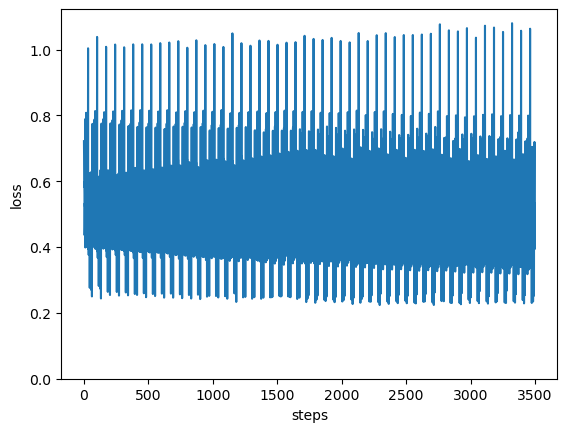

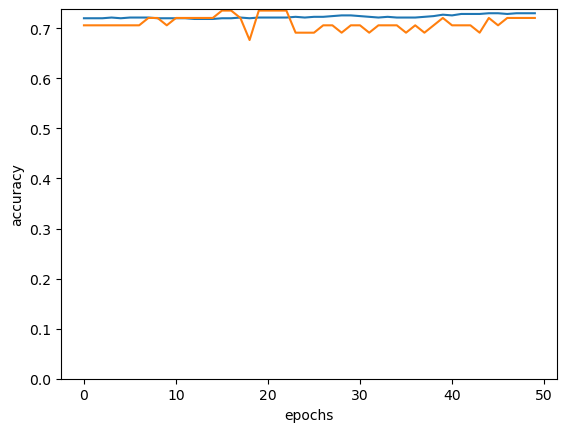

In [7]:
import matplotlib.pyplot as plt
 
# Plot the loss metrics, set the y-axis to start from 0
plt.plot(train_loss)
plt.xlabel("steps")
plt.ylabel("loss")
plt.ylim(0)
plt.show()
 
# plot the accuracy metrics
avg_train_acc = []
for i in range(n_epochs):
    start = i * batch_size
    average = sum(train_acc[start:start+batches_per_epoch]) / batches_per_epoch
    avg_train_acc.append(average)

plt.plot(avg_train_acc, label="train")
plt.plot(test_acc, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0)
plt.show()

Putting everything together, below is the complete code:

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)
epoch 0 step 0 loss 3.5553364753723145 accuracy 0.4000000059604645
epoch 0 step 1 loss 6.376173973083496 accuracy 0.20000000298023224
epoch 0 step 2 loss 1.3483216762542725 accuracy 0.5
epoch 0 step 3 loss 2.032258987426758 accuracy 0.6000000238418579
epoch 0 step 4 loss 1.6957037448883057 accuracy 0.699999988079071
epoch 0 step 5 loss 2.8132472038269043 accuracy 0.699999988079071
epoch 0 step 6 loss 0.5250999331474304 accuracy 0.6000000238418579
epoch 0 step 7 loss 0.8169538378715515 accuracy 0.5
epoch 0 step 8 loss 0.6875085234642029 accuracy 0.800000011920929
epoch 0 step 9 loss 0.9674491882324219 accuracy 0.699999988079071
epoch 0 step 10 loss 0.5003395080566406 accuracy 0.8999999761581421
epoch 0 step 11 loss 3.695000171661377 accuracy 0.4000000059604645
e

epoch 2 step 37 loss 1.5537712574005127 accuracy 0.20000000298023224
epoch 2 step 38 loss 0.7537144422531128 accuracy 0.699999988079071
epoch 2 step 39 loss 0.6152984499931335 accuracy 0.5
epoch 2 step 40 loss 1.3852170705795288 accuracy 0.4000000059604645
epoch 2 step 41 loss 1.5655914545059204 accuracy 0.6000000238418579
epoch 2 step 42 loss 1.408247947692871 accuracy 0.4000000059604645
epoch 2 step 43 loss 0.6066147089004517 accuracy 0.8999999761581421
epoch 2 step 44 loss 0.7327598333358765 accuracy 0.4000000059604645
epoch 2 step 45 loss 0.7229374051094055 accuracy 0.4000000059604645
epoch 2 step 46 loss 0.7597775459289551 accuracy 0.699999988079071
epoch 2 step 47 loss 0.5830714106559753 accuracy 0.800000011920929
epoch 2 step 48 loss 0.9958043098449707 accuracy 0.5
epoch 2 step 49 loss 0.7916034460067749 accuracy 0.6000000238418579
epoch 2 step 50 loss 0.6240452527999878 accuracy 0.6000000238418579
epoch 2 step 51 loss 0.6804447174072266 accuracy 0.699999988079071
epoch 2 step 5

epoch 5 step 3 loss 0.7718121409416199 accuracy 0.6000000238418579
epoch 5 step 4 loss 0.8983486294746399 accuracy 0.5
epoch 5 step 5 loss 1.0844258069992065 accuracy 0.4000000059604645
epoch 5 step 6 loss 0.6691458821296692 accuracy 0.5
epoch 5 step 7 loss 0.6271103024482727 accuracy 0.6000000238418579
epoch 5 step 8 loss 0.658728301525116 accuracy 0.6000000238418579
epoch 5 step 9 loss 0.6468305587768555 accuracy 0.6000000238418579
epoch 5 step 10 loss 0.6408551931381226 accuracy 0.6000000238418579
epoch 5 step 11 loss 0.6946367621421814 accuracy 0.6000000238418579
epoch 5 step 12 loss 0.6762595772743225 accuracy 0.5
epoch 5 step 13 loss 0.9249657392501831 accuracy 0.4000000059604645
epoch 5 step 14 loss 0.7276328206062317 accuracy 0.699999988079071
epoch 5 step 15 loss 0.698004424571991 accuracy 0.6000000238418579
epoch 5 step 16 loss 0.7888086438179016 accuracy 0.699999988079071
epoch 5 step 17 loss 0.7235372066497803 accuracy 0.5
epoch 5 step 18 loss 0.8329479098320007 accuracy 0.

epoch 7 step 13 loss 0.8931642770767212 accuracy 0.6000000238418579
epoch 7 step 14 loss 0.6866735219955444 accuracy 0.699999988079071
epoch 7 step 15 loss 0.7171379327774048 accuracy 0.6000000238418579
epoch 7 step 16 loss 0.7554857730865479 accuracy 0.6000000238418579
epoch 7 step 17 loss 0.7133342027664185 accuracy 0.6000000238418579
epoch 7 step 18 loss 0.7955951690673828 accuracy 0.6000000238418579
epoch 7 step 19 loss 0.8228015899658203 accuracy 0.4000000059604645
epoch 7 step 20 loss 0.8884425163269043 accuracy 0.6000000238418579
epoch 7 step 21 loss 0.5711883306503296 accuracy 0.699999988079071
epoch 7 step 22 loss 0.9337210655212402 accuracy 0.6000000238418579
epoch 7 step 23 loss 0.8164626359939575 accuracy 0.4000000059604645
epoch 7 step 24 loss 0.6779583692550659 accuracy 0.6000000238418579
epoch 7 step 25 loss 0.5100747346878052 accuracy 0.8999999761581421
epoch 7 step 26 loss 0.6213005781173706 accuracy 0.5
epoch 7 step 27 loss 0.6376904249191284 accuracy 0.69999998807907

epoch 9 step 44 loss 0.7755299806594849 accuracy 0.4000000059604645
epoch 9 step 45 loss 0.8001896739006042 accuracy 0.5
epoch 9 step 46 loss 0.6872521638870239 accuracy 0.699999988079071
epoch 9 step 47 loss 0.4595031142234802 accuracy 0.8999999761581421
epoch 9 step 48 loss 0.8002490997314453 accuracy 0.4000000059604645
epoch 9 step 49 loss 0.6002432107925415 accuracy 0.699999988079071
epoch 9 step 50 loss 0.5908561944961548 accuracy 0.699999988079071
epoch 9 step 51 loss 0.5931186079978943 accuracy 0.699999988079071
epoch 9 step 52 loss 0.5247251391410828 accuracy 0.699999988079071
epoch 9 step 53 loss 0.6131934523582458 accuracy 0.6000000238418579
epoch 9 step 54 loss 0.7960616946220398 accuracy 0.6000000238418579
epoch 9 step 55 loss 0.6418932676315308 accuracy 0.699999988079071
epoch 9 step 56 loss 0.8308825492858887 accuracy 0.5
epoch 9 step 57 loss 0.7939803600311279 accuracy 0.6000000238418579
epoch 9 step 58 loss 0.731054425239563 accuracy 0.699999988079071
epoch 9 step 59 lo

epoch 11 step 62 loss 0.5580109357833862 accuracy 0.800000011920929
epoch 11 step 63 loss 0.5371540188789368 accuracy 0.800000011920929
epoch 11 step 64 loss 0.7714539766311646 accuracy 0.6000000238418579
epoch 11 step 65 loss 0.7111347317695618 accuracy 0.800000011920929
epoch 11 step 66 loss 1.0625698566436768 accuracy 0.4000000059604645
epoch 11 step 67 loss 0.6607757806777954 accuracy 0.6000000238418579
epoch 11 step 68 loss 0.6430234909057617 accuracy 0.699999988079071
epoch 11 step 69 loss 0.6879159212112427 accuracy 0.699999988079071
End of 11, accuracy 0.5735294222831726
epoch 12 step 0 loss 0.5400130748748779 accuracy 0.699999988079071
epoch 12 step 1 loss 0.9193419218063354 accuracy 0.4000000059604645
epoch 12 step 2 loss 0.6690448522567749 accuracy 0.5
epoch 12 step 3 loss 0.7416903376579285 accuracy 0.6000000238418579
epoch 12 step 4 loss 0.8529769778251648 accuracy 0.5
epoch 12 step 5 loss 0.8131290674209595 accuracy 0.6000000238418579
epoch 12 step 6 loss 0.64851558208465

epoch 14 step 58 loss 0.713544487953186 accuracy 0.699999988079071
epoch 14 step 59 loss 1.1762712001800537 accuracy 0.20000000298023224
epoch 14 step 60 loss 0.5946800112724304 accuracy 0.800000011920929
epoch 14 step 61 loss 0.6920500993728638 accuracy 0.6000000238418579
epoch 14 step 62 loss 0.5198157429695129 accuracy 1.0
epoch 14 step 63 loss 0.5272476077079773 accuracy 0.800000011920929
epoch 14 step 64 loss 0.7623119950294495 accuracy 0.6000000238418579
epoch 14 step 65 loss 0.6846598386764526 accuracy 0.800000011920929
epoch 14 step 66 loss 1.0487282276153564 accuracy 0.4000000059604645
epoch 14 step 67 loss 0.641591489315033 accuracy 0.699999988079071
epoch 14 step 68 loss 0.6100143790245056 accuracy 0.699999988079071
epoch 14 step 69 loss 0.6742395162582397 accuracy 0.699999988079071
End of 14, accuracy 0.5735294222831726
epoch 15 step 0 loss 0.54315185546875 accuracy 0.699999988079071
epoch 15 step 1 loss 0.877164363861084 accuracy 0.4000000059604645
epoch 15 step 2 loss 0.6

epoch 17 step 22 loss 0.9084261655807495 accuracy 0.5
epoch 17 step 23 loss 0.8147041201591492 accuracy 0.5
epoch 17 step 24 loss 0.6866992712020874 accuracy 0.6000000238418579
epoch 17 step 25 loss 0.4953317642211914 accuracy 0.8999999761581421
epoch 17 step 26 loss 0.612514317035675 accuracy 0.6000000238418579
epoch 17 step 27 loss 0.5505431890487671 accuracy 0.800000011920929
epoch 17 step 28 loss 0.680642306804657 accuracy 0.6000000238418579
epoch 17 step 29 loss 0.5160393714904785 accuracy 0.699999988079071
epoch 17 step 30 loss 0.8035667538642883 accuracy 0.4000000059604645
epoch 17 step 31 loss 0.7863933444023132 accuracy 0.4000000059604645
epoch 17 step 32 loss 0.6311220526695251 accuracy 0.6000000238418579
epoch 17 step 33 loss 0.7221714854240417 accuracy 0.6000000238418579
epoch 17 step 34 loss 0.5379356145858765 accuracy 0.699999988079071
epoch 17 step 35 loss 0.71650230884552 accuracy 0.699999988079071
epoch 17 step 36 loss 0.7891173362731934 accuracy 0.5
epoch 17 step 37 l

epoch 19 step 50 loss 0.6066502928733826 accuracy 0.699999988079071
epoch 19 step 51 loss 0.5797706842422485 accuracy 0.699999988079071
epoch 19 step 52 loss 0.4602106511592865 accuracy 0.800000011920929
epoch 19 step 53 loss 0.4990104138851166 accuracy 0.800000011920929
epoch 19 step 54 loss 0.6847394108772278 accuracy 0.699999988079071
epoch 19 step 55 loss 0.5358844995498657 accuracy 0.800000011920929
epoch 19 step 56 loss 0.6771837472915649 accuracy 0.699999988079071
epoch 19 step 57 loss 0.7253715991973877 accuracy 0.699999988079071
epoch 19 step 58 loss 0.6995630860328674 accuracy 0.699999988079071
epoch 19 step 59 loss 1.1587070226669312 accuracy 0.20000000298023224
epoch 19 step 60 loss 0.5869734883308411 accuracy 0.699999988079071
epoch 19 step 61 loss 0.6768080592155457 accuracy 0.699999988079071
epoch 19 step 62 loss 0.4786296784877777 accuracy 1.0
epoch 19 step 63 loss 0.5366822481155396 accuracy 0.699999988079071
epoch 19 step 64 loss 0.7407357096672058 accuracy 0.60000002

epoch 22 step 32 loss 0.6599191427230835 accuracy 0.6000000238418579
epoch 22 step 33 loss 0.7145378589630127 accuracy 0.5
epoch 22 step 34 loss 0.5254201889038086 accuracy 0.800000011920929
epoch 22 step 35 loss 0.6758743524551392 accuracy 0.699999988079071
epoch 22 step 36 loss 0.738589882850647 accuracy 0.6000000238418579
epoch 22 step 37 loss 0.6036227345466614 accuracy 0.6000000238418579
epoch 22 step 38 loss 0.5176647901535034 accuracy 0.800000011920929
epoch 22 step 39 loss 0.9002026319503784 accuracy 0.4000000059604645
epoch 22 step 40 loss 0.8373317718505859 accuracy 0.4000000059604645
epoch 22 step 41 loss 0.7316385507583618 accuracy 0.6000000238418579
epoch 22 step 42 loss 0.5761547684669495 accuracy 0.800000011920929
epoch 22 step 43 loss 0.5006941556930542 accuracy 0.8999999761581421
epoch 22 step 44 loss 0.7665689587593079 accuracy 0.5
epoch 22 step 45 loss 0.6452586054801941 accuracy 0.6000000238418579
epoch 22 step 46 loss 0.49428343772888184 accuracy 0.8999999761581421

epoch 25 step 30 loss 0.7292686700820923 accuracy 0.4000000059604645
epoch 25 step 31 loss 0.7941375374794006 accuracy 0.4000000059604645
epoch 25 step 32 loss 0.6712253093719482 accuracy 0.6000000238418579
epoch 25 step 33 loss 0.7090925574302673 accuracy 0.5
epoch 25 step 34 loss 0.5174259543418884 accuracy 0.800000011920929
epoch 25 step 35 loss 0.6610507369041443 accuracy 0.699999988079071
epoch 25 step 36 loss 0.717103123664856 accuracy 0.6000000238418579
epoch 25 step 37 loss 0.5877388715744019 accuracy 0.699999988079071
epoch 25 step 38 loss 0.5155140161514282 accuracy 0.800000011920929
epoch 25 step 39 loss 0.8933737874031067 accuracy 0.4000000059604645
epoch 25 step 40 loss 0.8491331338882446 accuracy 0.4000000059604645
epoch 25 step 41 loss 0.7204537391662598 accuracy 0.6000000238418579
epoch 25 step 42 loss 0.5508203506469727 accuracy 0.800000011920929
epoch 25 step 43 loss 0.49665337800979614 accuracy 0.8999999761581421
epoch 25 step 44 loss 0.7614058256149292 accuracy 0.5


epoch 28 step 8 loss 0.538124680519104 accuracy 0.800000011920929
epoch 28 step 9 loss 0.4788743853569031 accuracy 0.800000011920929
epoch 28 step 10 loss 0.6140229105949402 accuracy 0.699999988079071
epoch 28 step 11 loss 0.5848265290260315 accuracy 0.699999988079071
epoch 28 step 12 loss 0.76197350025177 accuracy 0.5
epoch 28 step 13 loss 0.7249516248703003 accuracy 0.699999988079071
epoch 28 step 14 loss 0.5258969068527222 accuracy 0.800000011920929
epoch 28 step 15 loss 0.79925537109375 accuracy 0.4000000059604645
epoch 28 step 16 loss 0.5760070085525513 accuracy 0.699999988079071
epoch 28 step 17 loss 0.7171154022216797 accuracy 0.6000000238418579
epoch 28 step 18 loss 0.7120851278305054 accuracy 0.6000000238418579
epoch 28 step 19 loss 0.7293254137039185 accuracy 0.5
epoch 28 step 20 loss 0.6789675951004028 accuracy 0.699999988079071
epoch 28 step 21 loss 0.6155068874359131 accuracy 0.699999988079071
epoch 28 step 22 loss 0.8568760752677917 accuracy 0.5
epoch 28 step 23 loss 0.75

epoch 30 step 49 loss 0.47092118859291077 accuracy 0.8999999761581421
epoch 30 step 50 loss 0.5948201417922974 accuracy 0.800000011920929
epoch 30 step 51 loss 0.59505695104599 accuracy 0.800000011920929
epoch 30 step 52 loss 0.44287657737731934 accuracy 0.800000011920929
epoch 30 step 53 loss 0.48905476927757263 accuracy 0.800000011920929
epoch 30 step 54 loss 0.6189444065093994 accuracy 0.699999988079071
epoch 30 step 55 loss 0.4740481972694397 accuracy 0.8999999761581421
epoch 30 step 56 loss 0.6029953956604004 accuracy 0.699999988079071
epoch 30 step 57 loss 0.7737983465194702 accuracy 0.699999988079071
epoch 30 step 58 loss 0.67235267162323 accuracy 0.699999988079071
epoch 30 step 59 loss 1.0902156829833984 accuracy 0.30000001192092896
epoch 30 step 60 loss 0.5892473459243774 accuracy 0.699999988079071
epoch 30 step 61 loss 0.6545625329017639 accuracy 0.6000000238418579
epoch 30 step 62 loss 0.432934045791626 accuracy 1.0
epoch 30 step 63 loss 0.5822432637214661 accuracy 0.6999999

epoch 32 step 64 loss 0.6831802129745483 accuracy 0.6000000238418579
epoch 32 step 65 loss 0.6706395745277405 accuracy 0.800000011920929
epoch 32 step 66 loss 0.9728537797927856 accuracy 0.30000001192092896
epoch 32 step 67 loss 0.6191767454147339 accuracy 0.6000000238418579
epoch 32 step 68 loss 0.4825698435306549 accuracy 0.800000011920929
epoch 32 step 69 loss 0.658713698387146 accuracy 0.699999988079071
End of 32, accuracy 0.5588235259056091
epoch 33 step 0 loss 0.5866604447364807 accuracy 0.6000000238418579
epoch 33 step 1 loss 0.8183920979499817 accuracy 0.4000000059604645
epoch 33 step 2 loss 0.6858948469161987 accuracy 0.5
epoch 33 step 3 loss 0.7187261581420898 accuracy 0.6000000238418579
epoch 33 step 4 loss 0.7033987641334534 accuracy 0.6000000238418579
epoch 33 step 5 loss 0.5759210586547852 accuracy 0.800000011920929
epoch 33 step 6 loss 0.6337093114852905 accuracy 0.699999988079071
epoch 33 step 7 loss 0.5879019498825073 accuracy 0.699999988079071
epoch 33 step 8 loss 0.5

epoch 36 step 22 loss 0.8143378496170044 accuracy 0.5
epoch 36 step 23 loss 0.7012367248535156 accuracy 0.5
epoch 36 step 24 loss 0.605781078338623 accuracy 0.699999988079071
epoch 36 step 25 loss 0.4956802427768707 accuracy 0.8999999761581421
epoch 36 step 26 loss 0.6101463437080383 accuracy 0.6000000238418579
epoch 36 step 27 loss 0.5070575475692749 accuracy 0.800000011920929
epoch 36 step 28 loss 0.6323702931404114 accuracy 0.5
epoch 36 step 29 loss 0.534702718257904 accuracy 0.8999999761581421
epoch 36 step 30 loss 0.6663252115249634 accuracy 0.4000000059604645
epoch 36 step 31 loss 0.7482329607009888 accuracy 0.5
epoch 36 step 32 loss 0.7448453903198242 accuracy 0.6000000238418579
epoch 36 step 33 loss 0.6792302131652832 accuracy 0.5
epoch 36 step 34 loss 0.5164173245429993 accuracy 0.8999999761581421
epoch 36 step 35 loss 0.6124756336212158 accuracy 0.699999988079071
epoch 36 step 36 loss 0.6859650015830994 accuracy 0.6000000238418579
epoch 36 step 37 loss 0.5199717283248901 accu

epoch 38 step 40 loss 0.9006854891777039 accuracy 0.4000000059604645
epoch 38 step 41 loss 0.6888415217399597 accuracy 0.6000000238418579
epoch 38 step 42 loss 0.4797193109989166 accuracy 0.8999999761581421
epoch 38 step 43 loss 0.4779258370399475 accuracy 0.8999999761581421
epoch 38 step 44 loss 0.7245410084724426 accuracy 0.5
epoch 38 step 45 loss 0.5136565566062927 accuracy 0.699999988079071
epoch 38 step 46 loss 0.42529410123825073 accuracy 0.8999999761581421
epoch 38 step 47 loss 0.38753408193588257 accuracy 1.0
epoch 38 step 48 loss 0.6439228057861328 accuracy 0.699999988079071
epoch 38 step 49 loss 0.457876980304718 accuracy 0.8999999761581421
epoch 38 step 50 loss 0.5845922231674194 accuracy 0.800000011920929
epoch 38 step 51 loss 0.6018142700195312 accuracy 0.800000011920929
epoch 38 step 52 loss 0.4389781057834625 accuracy 0.800000011920929
epoch 38 step 53 loss 0.4938407838344574 accuracy 0.800000011920929
epoch 38 step 54 loss 0.5985279679298401 accuracy 0.699999988079071
e

epoch 40 step 43 loss 0.4760262370109558 accuracy 0.8999999761581421
epoch 40 step 44 loss 0.7208614349365234 accuracy 0.5
epoch 40 step 45 loss 0.5062318444252014 accuracy 0.699999988079071
epoch 40 step 46 loss 0.42056402564048767 accuracy 0.8999999761581421
epoch 40 step 47 loss 0.3871400058269501 accuracy 1.0
epoch 40 step 48 loss 0.6362223625183105 accuracy 0.699999988079071
epoch 40 step 49 loss 0.45638975501060486 accuracy 0.8999999761581421
epoch 40 step 50 loss 0.5864502191543579 accuracy 0.800000011920929
epoch 40 step 51 loss 0.5999304056167603 accuracy 0.800000011920929
epoch 40 step 52 loss 0.4393092095851898 accuracy 0.800000011920929
epoch 40 step 53 loss 0.4912703037261963 accuracy 0.800000011920929
epoch 40 step 54 loss 0.5949309468269348 accuracy 0.699999988079071
epoch 40 step 55 loss 0.44031423330307007 accuracy 0.8999999761581421
epoch 40 step 56 loss 0.550538182258606 accuracy 0.699999988079071
epoch 40 step 57 loss 0.7873448133468628 accuracy 0.699999988079071
ep

epoch 43 step 41 loss 0.680461585521698 accuracy 0.6000000238418579
epoch 43 step 42 loss 0.47232785820961 accuracy 0.800000011920929
epoch 43 step 43 loss 0.4723950922489166 accuracy 0.8999999761581421
epoch 43 step 44 loss 0.7148684859275818 accuracy 0.5
epoch 43 step 45 loss 0.4962448477745056 accuracy 0.699999988079071
epoch 43 step 46 loss 0.41449975967407227 accuracy 0.8999999761581421
epoch 43 step 47 loss 0.38624057173728943 accuracy 1.0
epoch 43 step 48 loss 0.6299903392791748 accuracy 0.699999988079071
epoch 43 step 49 loss 0.4550531804561615 accuracy 0.8999999761581421
epoch 43 step 50 loss 0.5889537334442139 accuracy 0.800000011920929
epoch 43 step 51 loss 0.596761167049408 accuracy 0.800000011920929
epoch 43 step 52 loss 0.4397304654121399 accuracy 0.800000011920929
epoch 43 step 53 loss 0.4876217246055603 accuracy 0.800000011920929
epoch 43 step 54 loss 0.5901373624801636 accuracy 0.699999988079071
epoch 43 step 55 loss 0.4342558979988098 accuracy 0.8999999761581421
epoch

epoch 46 step 23 loss 0.6473696827888489 accuracy 0.5
epoch 46 step 24 loss 0.5789679288864136 accuracy 0.699999988079071
epoch 46 step 25 loss 0.507847249507904 accuracy 0.8999999761581421
epoch 46 step 26 loss 0.5969513058662415 accuracy 0.6000000238418579
epoch 46 step 27 loss 0.5032942295074463 accuracy 0.800000011920929
epoch 46 step 28 loss 0.6215053200721741 accuracy 0.4000000059604645
epoch 46 step 29 loss 0.551435112953186 accuracy 0.800000011920929
epoch 46 step 30 loss 0.6417914628982544 accuracy 0.5
epoch 46 step 31 loss 0.7183352112770081 accuracy 0.5
epoch 46 step 32 loss 0.7774165868759155 accuracy 0.6000000238418579
epoch 46 step 33 loss 0.641463577747345 accuracy 0.5
epoch 46 step 34 loss 0.5111066102981567 accuracy 0.800000011920929
epoch 46 step 35 loss 0.5853506922721863 accuracy 0.699999988079071
epoch 46 step 36 loss 0.6711863279342651 accuracy 0.699999988079071
epoch 46 step 37 loss 0.4948771893978119 accuracy 0.699999988079071
epoch 46 step 38 loss 0.50372993946

epoch 49 step 14 loss 0.4835297465324402 accuracy 0.699999988079071
epoch 49 step 15 loss 0.7453368306159973 accuracy 0.5
epoch 49 step 16 loss 0.5300095677375793 accuracy 0.699999988079071
epoch 49 step 17 loss 0.7592424750328064 accuracy 0.6000000238418579
epoch 49 step 18 loss 0.7218574285507202 accuracy 0.6000000238418579
epoch 49 step 19 loss 0.7138679027557373 accuracy 0.5
epoch 49 step 20 loss 0.5964566469192505 accuracy 0.699999988079071
epoch 49 step 21 loss 0.6347004175186157 accuracy 0.6000000238418579
epoch 49 step 22 loss 0.7902640104293823 accuracy 0.5
epoch 49 step 23 loss 0.6343473196029663 accuracy 0.5
epoch 49 step 24 loss 0.5749835968017578 accuracy 0.699999988079071
epoch 49 step 25 loss 0.5108256340026855 accuracy 0.8999999761581421
epoch 49 step 26 loss 0.5956294536590576 accuracy 0.6000000238418579
epoch 49 step 27 loss 0.5015740394592285 accuracy 0.800000011920929
epoch 49 step 28 loss 0.6204668283462524 accuracy 0.4000000059604645
epoch 49 step 29 loss 0.553620

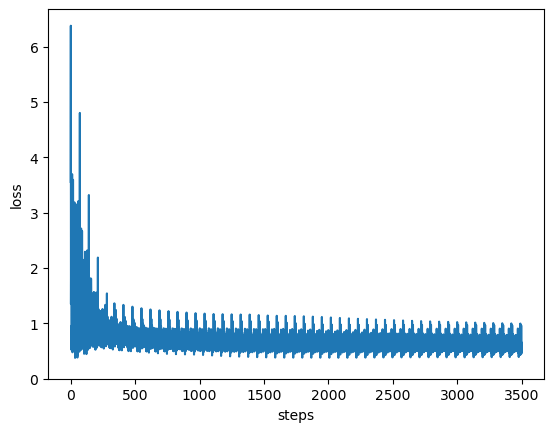

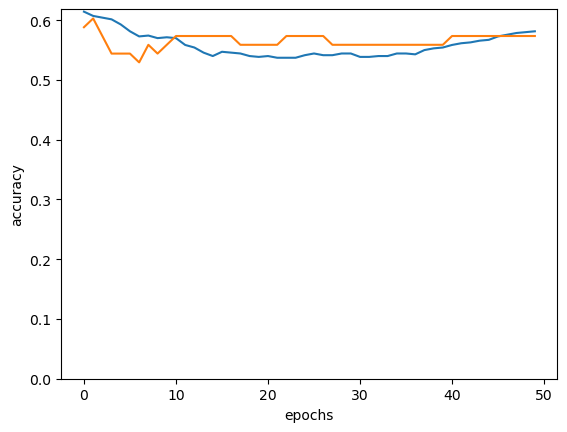

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
 
# load the dataset
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',') # split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
 
# split the dataset into training and test sets
Xtrain = X[:700]
ytrain = y[:700]
Xtest = X[700:]
ytest = y[700:]
 
model = nn.Sequential(
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print(model)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50    # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size
 
# collect statistics
train_loss = []
train_acc = []
test_acc = []
 
for epoch in range(n_epochs):
    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store metrics
        train_loss.append(float(loss))
        train_acc.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        print(f"epoch {epoch} step {i} loss {loss} accuracy {acc}")
    # evaluate model at end of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f"End of {epoch}, accuracy {acc}")

import matplotlib.pyplot as plt
 
# Plot the loss metrics
plt.plot(train_loss)
plt.xlabel("steps")
plt.ylabel("loss")
plt.ylim(0)
plt.show()
 
# plot the accuracy metrics
avg_train_acc = []
for i in range(n_epochs):
    start = i * batch_size
    average = sum(train_acc[start:start+batches_per_epoch]) / batches_per_epoch
    avg_train_acc.append(average)

plt.plot(avg_train_acc, label="train")
plt.plot(test_acc, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0)
plt.show()

The story does not end here. 
Indeed you can add more code to the training loop, especially in dealing with a more complex model. 
One example is checkpointing, which you may want to save your model (e.g., using pickle) so that, for any reason your program stops, you can restart the training loop from the middle. 
Another example is early stopping, which you can monitor for the accuracy you obtained with test set at end of each epoch, and interrupt the training if you don't see the model improves for a while. 
This is because probably you can't go further given the design of the model and you do not want to overfit.

## Using tqdm to Report the Training Progress

If you run the above code, you will find that there are a lot of lines print on the screen while the training loop is running. 
You screen may be cluttered. 
And you may also want to see an animated progress bar to better tell you how far you are in the training progress. 
The library tqdm is the popular tool to create th e progress bar. 
Converting the above code to use tqdm is cannot be easier:

In [12]:
import tqdm

for epoch in range(n_epochs):
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            Xbatch = Xtrain[start:start+batch_size]
            ybatch = ytrain[start:start+batch_size]
            # forward pass
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            acc = (y_pred.round() == ybatch).float().mean()
            # store metrics
            train_loss.append(float(loss))
            train_acc.append(float(acc))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(
                loss=float(loss),
                acc=f"{float(acc)*100:.2f}%"
            )
    # evaluate model at end of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f"End of {epoch}, accuracy {acc}")

Epoch 0: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.31batch/s, acc=70.00%, loss=0.661]


End of 0, accuracy 0.6029411554336548


Epoch 1: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 252.29batch/s, acc=70.00%, loss=0.661]


End of 1, accuracy 0.6029411554336548


Epoch 2: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 244.93batch/s, acc=70.00%, loss=0.66]


End of 2, accuracy 0.6029411554336548


Epoch 3: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 244.05batch/s, acc=70.00%, loss=0.66]


End of 3, accuracy 0.5882353186607361


Epoch 4: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 276.65batch/s, acc=70.00%, loss=0.659]


End of 4, accuracy 0.5882353186607361


Epoch 5: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 218.73batch/s, acc=60.00%, loss=0.659]


End of 5, accuracy 0.5882353186607361


Epoch 6: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.43batch/s, acc=60.00%, loss=0.659]


End of 6, accuracy 0.5882353186607361


Epoch 7: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.83batch/s, acc=60.00%, loss=0.659]


End of 7, accuracy 0.5882353186607361


Epoch 8: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 236.84batch/s, acc=60.00%, loss=0.658]


End of 8, accuracy 0.5882353186607361


Epoch 9: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.41batch/s, acc=60.00%, loss=0.658]


End of 9, accuracy 0.5882353186607361


Epoch 10: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.03batch/s, acc=60.00%, loss=0.658]


End of 10, accuracy 0.5735294222831726


Epoch 11: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.58batch/s, acc=60.00%, loss=0.657]


End of 11, accuracy 0.5735294222831726


Epoch 12: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 233.58batch/s, acc=60.00%, loss=0.657]


End of 12, accuracy 0.5735294222831726


Epoch 13: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 245.59batch/s, acc=60.00%, loss=0.657]


End of 13, accuracy 0.5735294222831726


Epoch 14: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 223.75batch/s, acc=60.00%, loss=0.656]


End of 14, accuracy 0.5882353186607361


Epoch 15: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 243.73batch/s, acc=60.00%, loss=0.656]


End of 15, accuracy 0.5882353186607361


Epoch 16: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 233.43batch/s, acc=60.00%, loss=0.656]


End of 16, accuracy 0.5882353186607361


Epoch 17: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 215.41batch/s, acc=60.00%, loss=0.656]


End of 17, accuracy 0.6029411554336548


Epoch 18: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.66batch/s, acc=60.00%, loss=0.655]


End of 18, accuracy 0.6029411554336548


Epoch 19: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.78batch/s, acc=60.00%, loss=0.654]


End of 19, accuracy 0.6029411554336548


Epoch 20: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.21batch/s, acc=60.00%, loss=0.654]


End of 20, accuracy 0.6029411554336548


Epoch 21: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.61batch/s, acc=60.00%, loss=0.653]


End of 21, accuracy 0.6029411554336548


Epoch 22: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.43batch/s, acc=60.00%, loss=0.653]


End of 22, accuracy 0.6029411554336548


Epoch 23: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 249.22batch/s, acc=60.00%, loss=0.653]


End of 23, accuracy 0.6029411554336548


Epoch 24: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 245.33batch/s, acc=60.00%, loss=0.652]


End of 24, accuracy 0.6029411554336548


Epoch 25: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.24batch/s, acc=60.00%, loss=0.652]


End of 25, accuracy 0.6029411554336548


Epoch 26: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 217.22batch/s, acc=60.00%, loss=0.651]


End of 26, accuracy 0.6029411554336548


Epoch 27: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 271.39batch/s, acc=60.00%, loss=0.651]


End of 27, accuracy 0.6029411554336548


Epoch 28: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 246.12batch/s, acc=60.00%, loss=0.651]


End of 28, accuracy 0.6029411554336548


Epoch 29: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 201.88batch/s, acc=60.00%, loss=0.65]


End of 29, accuracy 0.6029411554336548


Epoch 30: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 259.24batch/s, acc=60.00%, loss=0.65]


End of 30, accuracy 0.6029411554336548


Epoch 31: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 258.81batch/s, acc=60.00%, loss=0.649]


End of 31, accuracy 0.6029411554336548


Epoch 32: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 261.59batch/s, acc=60.00%, loss=0.65]


End of 32, accuracy 0.6029411554336548


Epoch 33: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 266.47batch/s, acc=60.00%, loss=0.649]


End of 33, accuracy 0.6029411554336548


Epoch 34: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 243.35batch/s, acc=60.00%, loss=0.649]


End of 34, accuracy 0.6029411554336548


Epoch 35: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 273.44batch/s, acc=60.00%, loss=0.649]


End of 35, accuracy 0.6029411554336548


Epoch 36: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 238.12batch/s, acc=60.00%, loss=0.649]


End of 36, accuracy 0.6029411554336548


Epoch 37: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.90batch/s, acc=60.00%, loss=0.649]


End of 37, accuracy 0.6029411554336548


Epoch 38: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.33batch/s, acc=60.00%, loss=0.647]


End of 38, accuracy 0.6029411554336548


Epoch 39: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 264.63batch/s, acc=60.00%, loss=0.648]


End of 39, accuracy 0.6029411554336548


Epoch 40: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 251.56batch/s, acc=60.00%, loss=0.647]


End of 40, accuracy 0.6029411554336548


Epoch 41: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 282.12batch/s, acc=60.00%, loss=0.647]


End of 41, accuracy 0.6176470518112183


Epoch 42: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.11batch/s, acc=60.00%, loss=0.646]


End of 42, accuracy 0.6176470518112183


Epoch 43: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 273.00batch/s, acc=60.00%, loss=0.646]


End of 43, accuracy 0.6176470518112183


Epoch 44: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 260.25batch/s, acc=60.00%, loss=0.646]


End of 44, accuracy 0.6176470518112183


Epoch 45: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 265.14batch/s, acc=60.00%, loss=0.646]


End of 45, accuracy 0.6176470518112183


Epoch 46: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.62batch/s, acc=60.00%, loss=0.646]


End of 46, accuracy 0.6176470518112183


Epoch 47: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 246.85batch/s, acc=60.00%, loss=0.646]


End of 47, accuracy 0.6176470518112183


Epoch 48: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 250.57batch/s, acc=70.00%, loss=0.646]


End of 48, accuracy 0.6176470518112183


Epoch 49: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 279.68batch/s, acc=70.00%, loss=0.646]

End of 49, accuracy 0.6176470518112183


The usage of tqdm is to create an iterator using trange() just like Python's range() function and you can read the number in a loop. 
You can access to the progress bar by updating its description or "postfix" data, but you have to do that before it exhausted its content. 
The `set_postfix()` function is powerful as it can show you anything.

In fact, there is a `tqdm()` function besides `trange()` that iterates over an existing list. 
You may find it easier to use and you can rewrite the above loop as follows:

In [13]:
starts = [i*batch_size for i in range(batches_per_epoch)]
 
for epoch in range(n_epochs):
    with tqdm.tqdm(starts, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            Xbatch = Xtrain[start:start+batch_size]
            ybatch = ytrain[start:start+batch_size]
            # forward pass
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            acc = (y_pred.round() == ybatch).float().mean()
            # store metrics
            train_loss.append(float(loss))
            train_acc.append(float(acc))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(
                loss=float(loss),
                acc=f"{float(acc)*100:.2f}%"
            )
    # evaluate model at end of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f"End of {epoch}, accuracy {acc}")

Epoch 0: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 227.19batch/s, acc=70.00%, loss=0.645]


End of 0, accuracy 0.6176470518112183


Epoch 1: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 234.17batch/s, acc=70.00%, loss=0.646]


End of 1, accuracy 0.6176470518112183


Epoch 2: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 211.78batch/s, acc=70.00%, loss=0.646]


End of 2, accuracy 0.6176470518112183


Epoch 3: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.84batch/s, acc=70.00%, loss=0.645]


End of 3, accuracy 0.6176470518112183


Epoch 4: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 219.33batch/s, acc=70.00%, loss=0.645]


End of 4, accuracy 0.6176470518112183


Epoch 5: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 220.91batch/s, acc=70.00%, loss=0.644]


End of 5, accuracy 0.6176470518112183


Epoch 6: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 253.08batch/s, acc=70.00%, loss=0.644]


End of 6, accuracy 0.6176470518112183


Epoch 7: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 244.53batch/s, acc=70.00%, loss=0.644]


End of 7, accuracy 0.6176470518112183


Epoch 8: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 252.34batch/s, acc=70.00%, loss=0.644]


End of 8, accuracy 0.6176470518112183


Epoch 9: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.77batch/s, acc=70.00%, loss=0.644]


End of 9, accuracy 0.6176470518112183


Epoch 10: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 230.71batch/s, acc=70.00%, loss=0.644]


End of 10, accuracy 0.6176470518112183


Epoch 11: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 227.07batch/s, acc=70.00%, loss=0.644]


End of 11, accuracy 0.6176470518112183


Epoch 12: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 229.38batch/s, acc=70.00%, loss=0.644]


End of 12, accuracy 0.6176470518112183


Epoch 13: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 224.33batch/s, acc=70.00%, loss=0.643]


End of 13, accuracy 0.6323529481887817


Epoch 14: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.66batch/s, acc=70.00%, loss=0.643]


End of 14, accuracy 0.6323529481887817


Epoch 15: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.13batch/s, acc=70.00%, loss=0.643]


End of 15, accuracy 0.6323529481887817


Epoch 16: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.83batch/s, acc=70.00%, loss=0.643]


End of 16, accuracy 0.6323529481887817


Epoch 17: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 234.50batch/s, acc=70.00%, loss=0.643]


End of 17, accuracy 0.6323529481887817


Epoch 18: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 233.29batch/s, acc=70.00%, loss=0.643]


End of 18, accuracy 0.6176470518112183


Epoch 19: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 232.36batch/s, acc=70.00%, loss=0.643]


End of 19, accuracy 0.6323529481887817


Epoch 20: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.17batch/s, acc=70.00%, loss=0.643]


End of 20, accuracy 0.6176470518112183


Epoch 21: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.34batch/s, acc=70.00%, loss=0.643]


End of 21, accuracy 0.6323529481887817


Epoch 22: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 238.77batch/s, acc=70.00%, loss=0.643]


End of 22, accuracy 0.6323529481887817


Epoch 23: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 233.46batch/s, acc=70.00%, loss=0.643]


End of 23, accuracy 0.6323529481887817


Epoch 24: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.98batch/s, acc=70.00%, loss=0.643]


End of 24, accuracy 0.6323529481887817


Epoch 25: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.24batch/s, acc=70.00%, loss=0.643]


End of 25, accuracy 0.6323529481887817


Epoch 26: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.50batch/s, acc=70.00%, loss=0.643]


End of 26, accuracy 0.6323529481887817


Epoch 27: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 262.26batch/s, acc=70.00%, loss=0.643]


End of 27, accuracy 0.6323529481887817


Epoch 28: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 242.60batch/s, acc=60.00%, loss=0.644]


End of 28, accuracy 0.6323529481887817


Epoch 29: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 249.22batch/s, acc=60.00%, loss=0.644]


End of 29, accuracy 0.6323529481887817


Epoch 30: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 237.06batch/s, acc=60.00%, loss=0.644]


End of 30, accuracy 0.6323529481887817


Epoch 31: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 263.26batch/s, acc=60.00%, loss=0.644]


End of 31, accuracy 0.6323529481887817


Epoch 32: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 243.77batch/s, acc=60.00%, loss=0.644]


End of 32, accuracy 0.6323529481887817


Epoch 33: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 265.49batch/s, acc=60.00%, loss=0.644]


End of 33, accuracy 0.6323529481887817


Epoch 34: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.32batch/s, acc=60.00%, loss=0.644]


End of 34, accuracy 0.6323529481887817


Epoch 35: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 240.43batch/s, acc=60.00%, loss=0.644]


End of 35, accuracy 0.6323529481887817


Epoch 36: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 261.66batch/s, acc=60.00%, loss=0.644]


End of 36, accuracy 0.6323529481887817


Epoch 37: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.14batch/s, acc=60.00%, loss=0.644]


End of 37, accuracy 0.6323529481887817


Epoch 38: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 262.14batch/s, acc=60.00%, loss=0.644]


End of 38, accuracy 0.6323529481887817


Epoch 39: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.90batch/s, acc=60.00%, loss=0.644]


End of 39, accuracy 0.6323529481887817


Epoch 40: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 249.65batch/s, acc=60.00%, loss=0.644]


End of 40, accuracy 0.6323529481887817


Epoch 41: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 265.56batch/s, acc=60.00%, loss=0.643]


End of 41, accuracy 0.6323529481887817


Epoch 42: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 269.85batch/s, acc=60.00%, loss=0.643]


End of 42, accuracy 0.6323529481887817


Epoch 43: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 206.72batch/s, acc=60.00%, loss=0.643]


End of 43, accuracy 0.6323529481887817


Epoch 44: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 205.67batch/s, acc=60.00%, loss=0.643]


End of 44, accuracy 0.6323529481887817


Epoch 45: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 223.14batch/s, acc=60.00%, loss=0.643]


End of 45, accuracy 0.6323529481887817


Epoch 46: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.74batch/s, acc=60.00%, loss=0.642]


End of 46, accuracy 0.6323529481887817


Epoch 47: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 245.46batch/s, acc=60.00%, loss=0.642]


End of 47, accuracy 0.6323529481887817


Epoch 48: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 263.48batch/s, acc=60.00%, loss=0.642]


End of 48, accuracy 0.6323529481887817


Epoch 49: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.03batch/s, acc=60.00%, loss=0.642]

End of 49, accuracy 0.6323529481887817


The following is the complete code (without the matplotlib plotting):

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
 
# load the dataset
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',') # split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
 
# split the dataset into training and test sets
Xtrain = X[:700]
ytrain = y[:700]
Xtest = X[700:]
ytest = y[700:]
 
model = nn.Sequential(
    nn.Linear(8, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print(model)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50    # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size
 
# collect statistics
train_loss = []
train_acc = []
test_acc = []
 
for epoch in range(n_epochs):
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            Xbatch = Xtrain[start:start+batch_size]
            ybatch = ytrain[start:start+batch_size]
            # forward pass
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            acc = (y_pred.round() == ybatch).float().mean()
            # store metrics
            train_loss.append(float(loss))
            train_acc.append(float(acc))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(
                loss=float(loss),
                acc=f"{float(acc)*100:.2f}%"
            )
    # evaluate model at end of epoch
    y_pred = model(Xtest)
    acc = (y_pred.round() == ytest).float().mean()
    test_acc.append(float(acc))
    print(f"End of {epoch}, accuracy {acc}")

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)


Epoch 0: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 241.97batch/s, acc=40.00%, loss=4.05]


End of 0, accuracy 0.3970588147640228


Epoch 1: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.26batch/s, acc=40.00%, loss=2.81]


End of 1, accuracy 0.3970588147640228


Epoch 2: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 223.55batch/s, acc=40.00%, loss=1.82]


End of 2, accuracy 0.4117647111415863


Epoch 3: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 223.76batch/s, acc=50.00%, loss=1.19]


End of 3, accuracy 0.529411792755127


Epoch 4: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.33batch/s, acc=60.00%, loss=0.882]


End of 4, accuracy 0.47058823704719543


Epoch 5: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.36batch/s, acc=60.00%, loss=0.794]


End of 5, accuracy 0.529411792755127


Epoch 6: 100%|███████████████████████████████████████████████████| 70/70 [00:00<00:00, 221.39batch/s, acc=70.00%, loss=0.81]


End of 6, accuracy 0.5441176295280457


Epoch 7: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 204.08batch/s, acc=70.00%, loss=0.833]


End of 7, accuracy 0.5735294222831726


Epoch 8: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 178.22batch/s, acc=60.00%, loss=0.841]


End of 8, accuracy 0.5882353186607361


Epoch 9: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 174.99batch/s, acc=60.00%, loss=0.844]


End of 9, accuracy 0.5882353186607361


Epoch 10: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.60batch/s, acc=60.00%, loss=0.845]


End of 10, accuracy 0.5882353186607361


Epoch 11: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.76batch/s, acc=60.00%, loss=0.832]


End of 11, accuracy 0.5882353186607361


Epoch 12: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.61batch/s, acc=60.00%, loss=0.821]


End of 12, accuracy 0.5882353186607361


Epoch 13: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 211.49batch/s, acc=60.00%, loss=0.813]


End of 13, accuracy 0.5882353186607361


Epoch 14: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 235.56batch/s, acc=60.00%, loss=0.806]


End of 14, accuracy 0.6029411554336548


Epoch 15: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 211.08batch/s, acc=60.00%, loss=0.799]


End of 15, accuracy 0.6029411554336548


Epoch 16: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 220.27batch/s, acc=50.00%, loss=0.793]


End of 16, accuracy 0.6029411554336548


Epoch 17: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 198.09batch/s, acc=50.00%, loss=0.787]


End of 17, accuracy 0.6029411554336548


Epoch 18: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 199.27batch/s, acc=50.00%, loss=0.782]


End of 18, accuracy 0.6029411554336548


Epoch 19: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 222.10batch/s, acc=50.00%, loss=0.777]


End of 19, accuracy 0.5882353186607361


Epoch 20: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 277.84batch/s, acc=50.00%, loss=0.772]


End of 20, accuracy 0.5882353186607361


Epoch 21: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 220.22batch/s, acc=50.00%, loss=0.767]


End of 21, accuracy 0.5882353186607361


Epoch 22: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 199.60batch/s, acc=50.00%, loss=0.762]


End of 22, accuracy 0.5882353186607361


Epoch 23: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 198.78batch/s, acc=50.00%, loss=0.759]


End of 23, accuracy 0.5882353186607361


Epoch 24: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 231.17batch/s, acc=50.00%, loss=0.755]


End of 24, accuracy 0.5882353186607361


Epoch 25: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 210.96batch/s, acc=50.00%, loss=0.751]


End of 25, accuracy 0.5882353186607361


Epoch 26: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 221.94batch/s, acc=50.00%, loss=0.746]


End of 26, accuracy 0.5882353186607361


Epoch 27: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 204.92batch/s, acc=50.00%, loss=0.744]


End of 27, accuracy 0.5882353186607361


Epoch 28: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 191.90batch/s, acc=50.00%, loss=0.74]


End of 28, accuracy 0.5882353186607361


Epoch 29: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 214.94batch/s, acc=50.00%, loss=0.737]


End of 29, accuracy 0.5882353186607361


Epoch 30: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 237.40batch/s, acc=50.00%, loss=0.734]


End of 30, accuracy 0.5882353186607361


Epoch 31: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 215.06batch/s, acc=50.00%, loss=0.73]


End of 31, accuracy 0.6029411554336548


Epoch 32: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 183.92batch/s, acc=50.00%, loss=0.73]


End of 32, accuracy 0.6029411554336548


Epoch 33: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 213.83batch/s, acc=50.00%, loss=0.727]


End of 33, accuracy 0.6029411554336548


Epoch 34: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 200.69batch/s, acc=50.00%, loss=0.727]


End of 34, accuracy 0.6029411554336548


Epoch 35: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 223.25batch/s, acc=50.00%, loss=0.723]


End of 35, accuracy 0.6029411554336548


Epoch 36: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 204.09batch/s, acc=50.00%, loss=0.722]


End of 36, accuracy 0.6029411554336548


Epoch 37: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 194.48batch/s, acc=50.00%, loss=0.719]


End of 37, accuracy 0.6029411554336548


Epoch 38: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 190.20batch/s, acc=50.00%, loss=0.719]


End of 38, accuracy 0.6029411554336548


Epoch 39: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 228.23batch/s, acc=50.00%, loss=0.717]


End of 39, accuracy 0.6029411554336548


Epoch 40: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 243.68batch/s, acc=50.00%, loss=0.715]


End of 40, accuracy 0.6029411554336548


Epoch 41: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 176.23batch/s, acc=50.00%, loss=0.712]


End of 41, accuracy 0.6029411554336548


Epoch 42: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 208.89batch/s, acc=50.00%, loss=0.714]


End of 42, accuracy 0.6029411554336548


Epoch 43: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 215.92batch/s, acc=50.00%, loss=0.709]


End of 43, accuracy 0.6029411554336548


Epoch 44: 100%|██████████████████████████████████████████████████| 70/70 [00:00<00:00, 192.19batch/s, acc=50.00%, loss=0.71]


End of 44, accuracy 0.6029411554336548


Epoch 45: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 221.76batch/s, acc=50.00%, loss=0.707]


End of 45, accuracy 0.6029411554336548


Epoch 46: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 234.02batch/s, acc=50.00%, loss=0.706]


End of 46, accuracy 0.6029411554336548


Epoch 47: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 216.82batch/s, acc=50.00%, loss=0.705]


End of 47, accuracy 0.6029411554336548


Epoch 48: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 247.18batch/s, acc=60.00%, loss=0.703]


End of 48, accuracy 0.6029411554336548


Epoch 49: 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 248.61batch/s, acc=50.00%, loss=0.703]

End of 49, accuracy 0.6029411554336548


## Summary

In this tutorial, you looked in detail on how to properly set up a training loop for a PyTorch model. 
In particular, you saw

- What are the elements need to implement in a training loop
- How a training loop connects the training data to the gradient descent optimizer
- How to collect information in the training loop, and display them